In [1]:
import os
gpu_id = 0
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]=str(gpu_id)

In [2]:
import torch
curr_device = torch.cuda.current_device()
torch.cuda.get_device_name(curr_device)

'GeForce GTX 1080 Ti'

In [3]:
import numpy as np

from networks.faceid.sphereface import sphere20a
from networks.denoise.pydl import ResDNet
from networks.denoise.pydl import UDNet
from networks.denoise.pydl import UDNetPA

In [4]:
faceid = sphere20a(feature=True)

sphereface_wo_noise = "/home/safin/ckpt/sphereface_clean/sphere20a_19.pth"
faceid_ckpt = torch.load(sphereface_wo_noise)
faceid.load_state_dict(faceid_ckpt)
faceid = faceid.cuda()

In [5]:
from datasets.lfw import LFWDataset
from torchvision import transforms
transform = transforms.Compose([
                         transforms.ToTensor()
                     ])
test_dataset =  LFWDataset("/home/safin/datasets/lfw/lfw-sphereface/", "/home/safin/datasets/lfw/pairsDevTrain.txt", transform, "png")

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.mixture import GaussianMixture

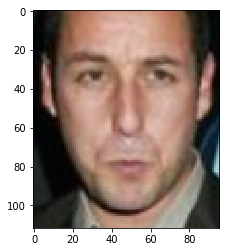

In [7]:
person_id = 10
image = test_dataset[person_id][0]
plt.imshow(image.permute(1,2,0))

In [8]:
from networks.denoise.pydl import UDNetPA
denoiser = UDNetPA(kernel_size = (5, 5),
                input_channels = 3,
                output_features = 32,
                rpa_depth = 7,
                shortcut=(False,True))
denoiser_ckpt = torch.load("/home/safin/ckpt/1st_udnetpa/weigths_31")
denoiser.load_state_dict(denoiser_ckpt)
denoiser.cuda()

UDNetPA(depth = 7, convWeightSharing = True, shortcut = (False, True, True, True, True, True, True))

In [9]:
import sys
sys.path.append("/home/safin/")
from pydl import utils as pydlutil

In [15]:
(torch.rand((batch_size, *face_size))*std/MAX_PIXEL).max()

tensor(0.2157)

In [16]:
std/MAX_PIXEL

0.21568627450980393

In [10]:
emb_clean = faceid((image*2 - 1).unsqueeze(0).cuda())
face_size = test_dataset[person_id][0].shape
_, emb_dim = emb_clean.shape

n_iterations = 100
batch_size = 32
ans = np.empty(((n_iterations*batch_size), emb_dim))
ans2 = np.empty(((n_iterations*batch_size), emb_dim))

std = 55
MAX_PIXEL=255

for i in range(n_iterations):
    img = (test_dataset[person_id][0] + torch.rand((batch_size, *face_size))*std/MAX_PIXEL).clamp(0,1)
    faceid_input = 2*img - 1 #(img*255 - 127.5)/128
    emb_noised = faceid(faceid_input.cuda()) 
    diff = emb_noised - emb_clean
    ans[i*batch_size:(i+1)*batch_size] = diff.cpu().data.tolist()

    denoiser_input = 255*img
    sigma = pydlutil.wmad_estimator(denoiser_input)
    sigma = sigma.cuda()
    denoised = denoiser(denoiser_input.cuda(), sigma)
    faceid_input = (denoised - 127.5)/127.5
    emb_denoised = faceid(faceid_input.cuda()) 
    diff = emb_denoised - emb_clean
    ans2[i*batch_size:(i+1)*batch_size] = diff.cpu().data.tolist()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


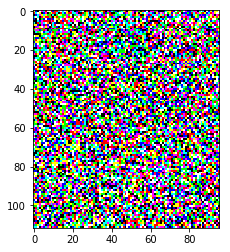

In [30]:
plt.imshow(100*((img[0]).data.permute(1,2,0).cpu().numpy() - (img[3]).data.permute(1,2,0).cpu().numpy()))

In [43]:
(denoised[0]/255).data.permute(1,2,0).cpu().numpy() - image.data.permute(1,2,0).cpu().numpy()

array([[[ 0.1460633 ,  0.13954763,  0.0940522 ],
        [ 0.10580938,  0.0688963 ,  0.12391242],
        [ 0.12548773,  0.0603485 ,  0.06509175],
        ...,
        [ 0.12488706,  0.11497776,  0.14234796],
        [ 0.20026368,  0.11966038,  0.06365123],
        [ 0.15743802,  0.12809747,  0.15181439]],

       [[ 0.0956331 ,  0.04588797,  0.10093843],
        [ 0.11444893,  0.09458039,  0.10146175],
        [ 0.12861001,  0.07802194,  0.09680405],
        ...,
        [ 0.13118072,  0.10017432,  0.09601457],
        [ 0.15848781,  0.12409227,  0.08115676],
        [ 0.14114617,  0.15174238,  0.18103372]],

       [[ 0.14079845,  0.07017282,  0.04399743],
        [ 0.10048324,  0.10128018,  0.12469896],
        [ 0.1144886 ,  0.11012587,  0.12146848],
        ...,
        [ 0.13929972,  0.10559206,  0.09845063],
        [ 0.16852169,  0.12770037,  0.13362111],
        [ 0.15601237,  0.10115544,  0.02457309]],

       ...,

       [[ 0.122919  ,  0.09686974,  0.12903967],
        [ 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


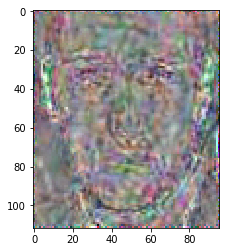

In [52]:
plt.imshow(5*( (denoised[0]/255).data.permute(1,2,0).cpu().numpy() - image.data.permute(1,2,0).cpu().numpy() ))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


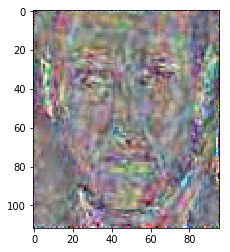

In [51]:
plt.imshow(5*( (denoised[1]/255).data.permute(1,2,0).cpu().numpy() - image.data.permute(1,2,0).cpu().numpy() ))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


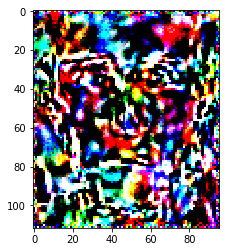

In [28]:
plt.imshow(100*((denoised[0]/255).data.permute(1,2,0).cpu().numpy() - (denoised[3]/255).data.permute(1,2,0).cpu().numpy()))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


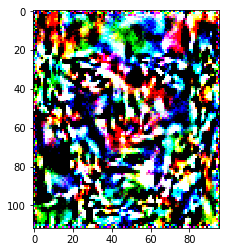

In [29]:
plt.imshow(100*((denoised[0]/255).data.permute(1,2,0).cpu().numpy() - (denoised[4]/255).data.permute(1,2,0).cpu().numpy()))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


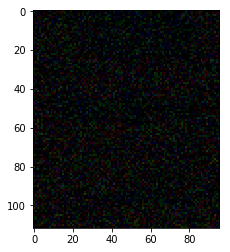

In [36]:
plt.imshow(img[5].data.permute(1,2,0).cpu().numpy()-img[4].data.permute(1,2,0).cpu().numpy())

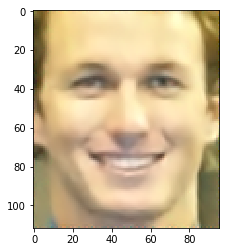

In [18]:
plt.imshow((faceid_input[5].data.permute(1,2,0).cpu().numpy()+1)/2)

/home/safin/miniconda3/envs/py36ml/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


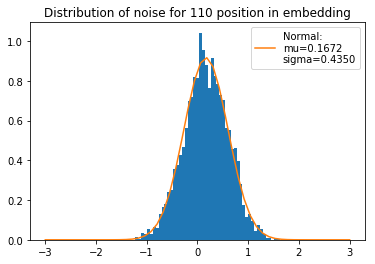

In [12]:
n_pos = 110
t = ans[:, n_pos].reshape(-1,1)
gmm = GaussianMixture(n_components=1)
gmm.fit(t)

sigma = np.sqrt(gmm.covariances_).reshape(1)
mu = gmm.means_.reshape(1)
x = np.linspace(-int(np.ceil(5*sigma)),int(np.ceil(5*sigma)))
y = 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (x - mu)**2 / (2 * sigma**2))

tmp = plt.hist(t, bins=50, normed=True)
plt.plot(x, y, label="Normal: \nmu=%.4f\nsigma=%.4f" % (mu, sigma))
plt.title("Distribution of noise for %s position in embedding" % n_pos)
plt.legend()

/home/safin/miniconda3/envs/py36ml/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


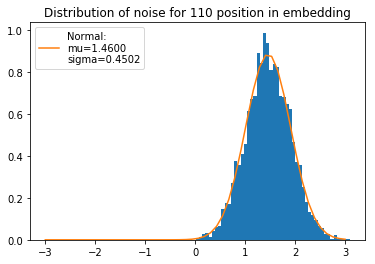

In [11]:
n_pos = 110
t = ans2[:, n_pos].reshape(-1,1)
gmm = GaussianMixture(n_components=1)
gmm.fit(t)

sigma = np.sqrt(gmm.covariances_).reshape(1)
mu = gmm.means_.reshape(1)
x = np.linspace(-int(np.ceil(5*sigma)),int(np.ceil(5*sigma)))
y = 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (x - mu)**2 / (2 * sigma**2))

tmp = plt.hist(t, bins=50, normed=True)
plt.plot(x, y, label="Normal: \nmu=%.4f\nsigma=%.4f" % (mu, sigma))
plt.title("Distribution of noise for %s position in embedding" % n_pos)
plt.legend()

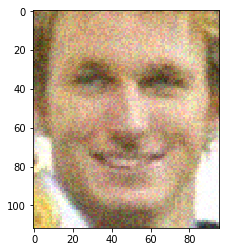

In [43]:
plt.imshow((img[0].permute(1,2,0)+1)/2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


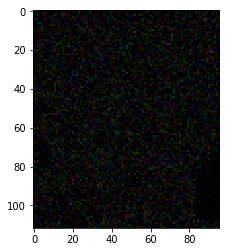

In [45]:
plt.imshow((img[1].permute(1,2,0)+1)/2 - (img[0].permute(1,2,0)+1)/2)

/home/safin/miniconda3/envs/py36ml/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


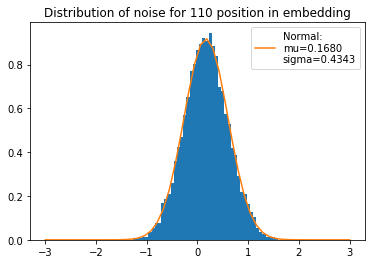

In [74]:
n_pos = 110
t = ans2[:, n_pos].reshape(-1,1)
gmm = GaussianMixture(n_components=1)
gmm.fit(t)

sigma = np.sqrt(gmm.covariances_).reshape(1)
mu = gmm.means_.reshape(1)
x = np.linspace(-int(np.ceil(5*sigma)),int(np.ceil(5*sigma)))
y = 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (x - mu)**2 / (2 * sigma**2))

tmp = plt.hist(t, bins=50, normed=True)
plt.plot(x, y, label="Normal: \nmu=%.4f\nsigma=%.4f" % (mu, sigma))
plt.title("Distribution of noise for %s position in embedding" % n_pos)
plt.legend()

/home/safin/miniconda3/envs/py36ml/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


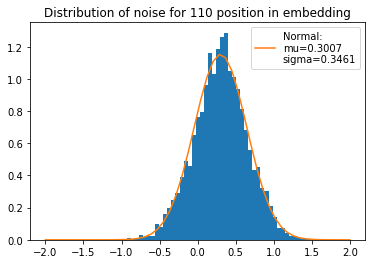

In [72]:
n_pos = 110
t = ans[:, n_pos].reshape(-1,1)
gmm = GaussianMixture(n_components=1)
gmm.fit(t)

sigma = np.sqrt(gmm.covariances_).reshape(1)
mu = gmm.means_.reshape(1)
x = np.linspace(-int(np.ceil(5*sigma)),int(np.ceil(5*sigma)))
y = 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (x - mu)**2 / (2 * sigma**2))

tmp = plt.hist(t, bins=50, normed=True)
plt.plot(x, y, label="Normal: \nmu=%.4f\nsigma=%.4f" % (mu, sigma))
plt.title("Distribution of noise for %s position in embedding" % n_pos)
plt.legend()

(array([   7.,   33.,  226.,  688., 1464., 1821., 1326.,  611.,  194.,
          30.]),
 array([-1.52864051, -1.21643711, -0.90423372, -0.59203032, -0.27982693,
         0.03237647,  0.34457986,  0.65678326,  0.96898665,  1.28119005,
         1.59339345]),
 <a list of 10 Patch objects>)

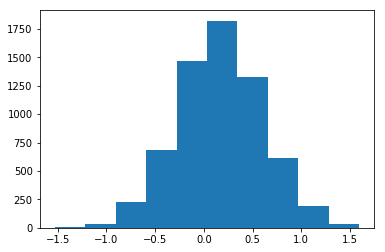

In [71]:
plt.hist(t)

In [75]:
import scipy
scipy.stats.normaltest(t)

NormaltestResult(statistic=array([0.00340576]), pvalue=array([0.99829857]))

In [76]:
import scipy
scipy.stats.normaltest(0.3*np.random.randn(6400)+0.3)

NormaltestResult(statistic=3.81188821013453, pvalue=0.14868220471561805)

(array([0.02141546, 0.        , 0.03212318, 0.02141546, 0.02855394,
        0.03569243, 0.11064652, 0.10350803, 0.13563122, 0.19987758,
        0.3105241 , 0.4283091 , 0.43187835, 0.57821729, 0.60320199,
        0.71741775, 0.86732594, 1.06720352, 1.12788064, 1.34917368,
        1.33132747, 1.37058913, 1.32775822, 1.34203519, 1.18855776,
        1.09575746, 1.05649579, 1.08861897, 0.81735654, 0.82806427,
        0.6710176 , 0.65317138, 0.41046289, 0.37477047, 0.28197016,
        0.23557001, 0.18203137, 0.11064652, 0.117785  , 0.03569243,
        0.06067712, 0.0249847 , 0.02855394, 0.01427697, 0.00356924,
        0.00713849, 0.00713849, 0.00356924, 0.        , 0.00356924]),
 array([-0.68865404, -0.64487724, -0.60110045, -0.55732365, -0.51354686,
        -0.46977006, -0.42599326, -0.38221647, -0.33843967, -0.29466288,
        -0.25088608, -0.20710929, -0.16333249, -0.1195557 , -0.0757789 ,
        -0.03200211,  0.01177469,  0.05555148,  0.09932828,  0.14310507,
         0.18688187,  0.23

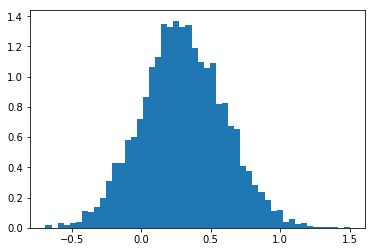

In [60]:
plt.hist(0.3*np.random.randn(6400)+0.3, bins=50, normed=True)